<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Universe Selection

In this notebook we will use Zipline's Pipeline API to select our daily universe of stocks. 

## Universe size
Due to the size of the US stock market, universe selection is a crucial first step for any Zipline strategy that targets US stocks. The limiting factor for universe size is the concurrent ticker limit for real-time data collection. There are about 8,000 listed US stocks, but most likely you will not be able stream real-time data for all 8,000 stocks at once, due to concurrent ticker limits imposed by your data provider and/or database performance impact. (See the [usage guide](https://www.quantrocket.com/p/realtimeperf) for more on this topic.) Therefore, a recommended first task is to use the Pipeline API to screen the entire US stock universe each day and select a smaller universe of candidate stocks for which to request real-time data and make trading decisions.

## Pipeline screen rules

Ideally, we would screen for stocks with opening gaps, since those are the stocks we want to trade, but this won't work, because detecting opening gaps requires real-time data (in live trading) in order to know the opening price. The pipeline screen must only use rules that can be known before the market opens. We will use the following rules: 

* common stocks only (no ETFs, ADRs, or preferred stocks)
* large-cap, liquid stocks only (top 10% by dollar volume)
* stocks must be trading above their 20-day moving average 

## Test the number of candidate stocks

One benefit of running a pipeline interactively is that we can see how many candidate stocks pass the screen and iteratively refine our rules until the resulting universe is a suitable size.  

First, we set the default bundle:

In [1]:
from quantrocket.zipline import set_default_bundle
set_default_bundle("usstock-1min")

{'status': 'successfully set default bundle'}

Then, we define a pipeline whose `screen` is based on the above universe selection rules. We also compute two `columns` that, while not yet necessary at this exploratory stage, will be useful later in identifying gaps: the prior day's low, and the standard deviation of the stock's closing price (which will be used to make sure the gap is sufficiently large). 

In [2]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume, SimpleMovingAverage, ExponentialWeightedMovingStdDev
from zipline.pipeline.data.equity_pricing import EquityPricing
from zipline.pipeline.data.master import SecuritiesMaster

# Rules for screen
# - common stocks only
# - must be liquid (top 10% by dollar volume)
# - must be above 20-day moving average
# - must not be too cheap or too expensive
mavg = SimpleMovingAverage(
    window_length = 20, inputs = [EquityPricing.close])
        
are_common_stocks = SecuritiesMaster.usstock_SecurityType2.latest.eq("Common Stock")
are_liquid = AverageDollarVolume(window_length=30).percentile_between(90,100)
are_above_mavg = EquityPricing.close.latest > mavg
are_not_too_cheap = EquityPricing.close.latest > 10
are_not_too_expensive = EquityPricing.close.latest < 2000
    
pipeline = Pipeline(
    columns={
        # mavg, prior_low and std will be needed later for the intraday trading logic
        "mavg": mavg,
        "prior_low": EquityPricing.low.latest,
        "std": ExponentialWeightedMovingStdDev(
            inputs=[EquityPricing.close], 
            window_length=63, 
            decay_rate=0.99)
    },
    screen=(
        are_common_stocks 
        & are_liquid 
        & are_above_mavg 
        & are_not_too_cheap
        & are_not_too_expensive
    )
)

Then we run the pipeline over a representative date range and plot the number of securities that passed the screen each day:

/tmp/zipline/zipline/pipeline/filters/filter.py:382: RuntimeWarning: invalid value encountered in less_equal
  return (lower_bounds <= data) & (data <= upper_bounds)


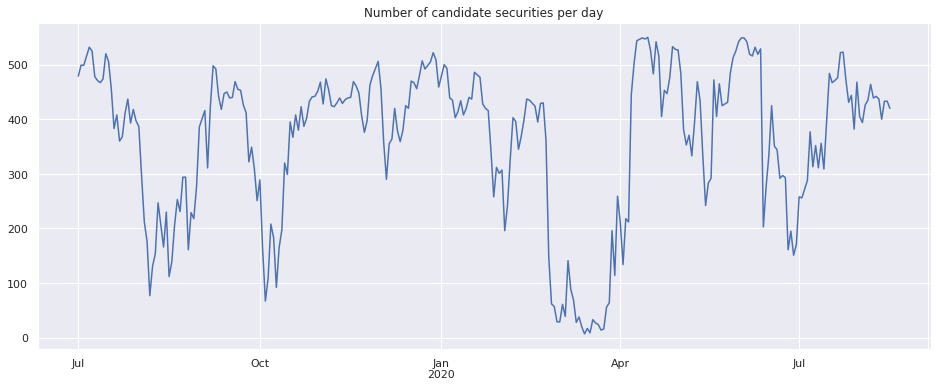

In [3]:
from zipline.research import run_pipeline
candidates = run_pipeline(pipeline, start_date="2019-07-01", end_date="2020-08-15")
candidates.groupby(candidates.index.get_level_values(0))["prior_low"].count().plot(title="Number of candidate securities per day")

If the number of candidate securities is too high for your real-time data limits, you can experiment with the pipeline screen until the number is more suitable. 

Also keep in mind that you need not collect real-time data for every security that passes your screen. You could further filter the pipeline output in `before_trading_start()` and only initiate real-time data collection for this subset of securities. For example, if you wanted to impose a hard 100-ticker limit on real-time data collection, but your pipeline might return more than 100 securities, you could rank the pipeline output by one of your columns and take the top 100:

In [4]:
# Isolate a single day of pipeline output, the same as is provided to trading strategies
day_candidates = candidates.xs("2020-08-13")

# Take the top 100 most volatile
day_candidates = day_candidates.sort_values(by=["std"], ascending=False).iloc[:100]
day_candidates.head()

,mavg,prior_low,std
Equity(FIBBG000N9MNX3 [TSLA]),1495.7860,1435.000,288.116932
Equity(FIBBG000BCZBF1 [SAM]),767.7845,799.660,122.199198
Equity(FIBBG000GQPB11 [MELI]),1085.3325,1101.216,114.804898
Equity(FIBBG000BLBVN4 [BKNG]),1720.0895,1805.500,79.225988
Equity(FIBBG000BZCKH3 [MTD]),907.5960,947.981,68.048727


## Code Reuse

An an optional step to facilitate code reuse, we copy our pipeline code to [pipeline.py](pipeline.py) which will allow us to import it in other notebooks and in our Zipline strategy, without re-typing it every time.

***

## *Next Up*

Part 3: [Interactive Strategy Development](Part3-Interactive-Strategy-Development.ipynb)